# 3b. Fitting carbonate and SO$_2$ peaks
- This notebook shows how to fit secondary peaks, such as carbonate and S-rich phases in vapour bubbles and fluid inclusions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from tqdm import tqdm
pf.__version__

'0.0.77'

In [2]:
# Here, we are loading in the settings files from Step1. If all you want to do is find secondary phases, paste that code here
meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower=pf.get_settings()

In [3]:
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'Spec', 'CRR', 'secphase']
Diad_Files=pf.get_files(path=spectra_path, file_ext=file_ext, exclude_str=exclude_str)
print(Diad_Files)
File_df=pd.DataFrame(data={'filename': Diad_Files})

['02 K23_10_FIA_50X.txt', '05 K23_1_FIA_50X.txt', '06 K23_1_FIA_50X_r2_longeraq.txt', '08 K23_2_FIA_50X.txt', '09 K23_2_FIB_50X.txt', '11 K23_2_FIC_50X.txt', '13 K23_4_FIA_50X.txt', '14 K23_4_FIB_50X.txt', '16 K23_6_FIA_50X.txt', '17 K23_7_FIA_50X.txt', '19 K23_7_FIB_50X.txt', '20 K23_7_FIC_50X.txt', '21 K23_9_FIA_50X.txt', '23 K23_101_FID_50X.txt', '24 K23_101_FIC_50X.txt', '26 K23_102_FIA.txt']


## Plot spectra in a given region of space to examine secondary peaks or not

### You'll need to tweak the peak parameters to find them
- height = minimum height a peak should have to be identified
- threshold = required vertical distance between a peak and its neighbours
- distance = required horizontal distance bewteen neighbouring peaks. 
- prominence = required prominence of peaks
- width = width of peaks


## Best method - uses scipy find peaks, with the same peak parameters as used throughout Diad Fit

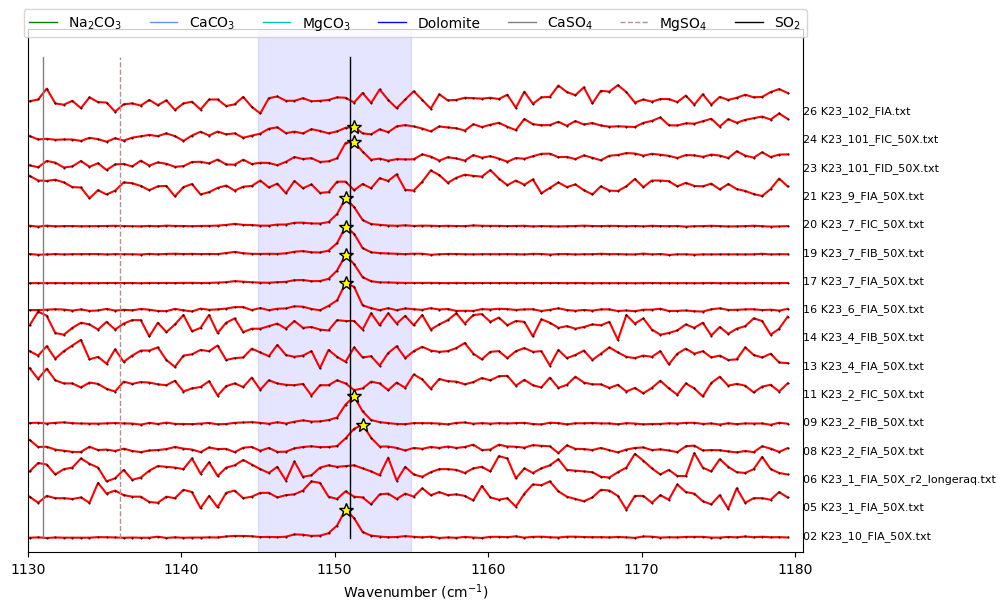

In [9]:
prominence_SO2=20
height_SO2=20
width_SO2=1
threshold_SO2=1

SO2_peaks_scipy, x_data_scipy, y_data_scipy, fig_scipy=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=filetype, find_peaks_filter=True,  
xlim_peaks=[1145, 1155], xlim_plot=[1130, 1180], yscale=0.3,
prominence=prominence_SO2, height=height_SO2, width=width_SO2, threshold=threshold_SO2)

SO2_peaks=SO2_peaks_scipy

In [10]:
SO2_peaks

,pos,height,prom,file_names
0,1150.710207,1352.750000,396.250,02 K23_10_FIA_50X.txt
1,NaN,NaN,NaN,05 K23_1_FIA_50X.txt
2,NaN,NaN,NaN,06 K23_1_FIA_50X_r2_longeraq.txt
3,1151.820890,721.250000,26.250,08 K23_2_FIA_50X.txt
4,1151.265577,819.750000,121.625,09 K23_2_FIB_50X.txt
5,NaN,NaN,NaN,11 K23_2_FIC_50X.txt
6,NaN,NaN,NaN,13 K23_4_FIA_50X.txt
7,NaN,NaN,NaN,14 K23_4_FIB_50X.txt
8,1150.710207,714.750000,47.000,16 K23_6_FIA_50X.txt
9,1150.710207,1530.500000,834.875,17 K23_7_FIA_50X.txt


## Find peaks filtering on peak position and prominence so just loop through these files

In [11]:
# Remove the ones where it didnt find SO2
SO2_notNa=np.isnan(SO2_peaks['pos'])
# Remove ones with a prominence less than this. 
prom_filt=10
SO2_filter=((SO2_peaks['prom']>10))&(~SO2_notNa)
print('Number kept with this filter:')
print(sum(SO2_filter))
print('Number discarded:')
print(sum(~SO2_filter&(~SO2_notNa)))
filenames_SO2=list(File_df['filename'].loc[SO2_filter])
print('filenames with SO2:')
print(filenames_SO2)

Number kept with this filter:
8
Number discarded:
1
filenames with SO2:
['02 K23_10_FIA_50X.txt', '08 K23_2_FIA_50X.txt', '09 K23_2_FIB_50X.txt', '16 K23_6_FIA_50X.txt', '17 K23_7_FIA_50X.txt', '19 K23_7_FIB_50X.txt', '20 K23_7_FIC_50X.txt', '23 K23_101_FID_50X.txt']


### Choose a filename to test peak fits

In [12]:
if sum(SO2_filter)>0:
    filename=filenames_SO2[0]

### Set up configuration file for S peak fitting

generic_peak_config(name='SO2', lower_bck=[1110, 1130], upper_bck=[1160, 1180], model_name='Spline', x_range_bck=5, N_poly_carb_bck=1, amplitude=1000, cent=1150, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1, int_cut_off=0.08)


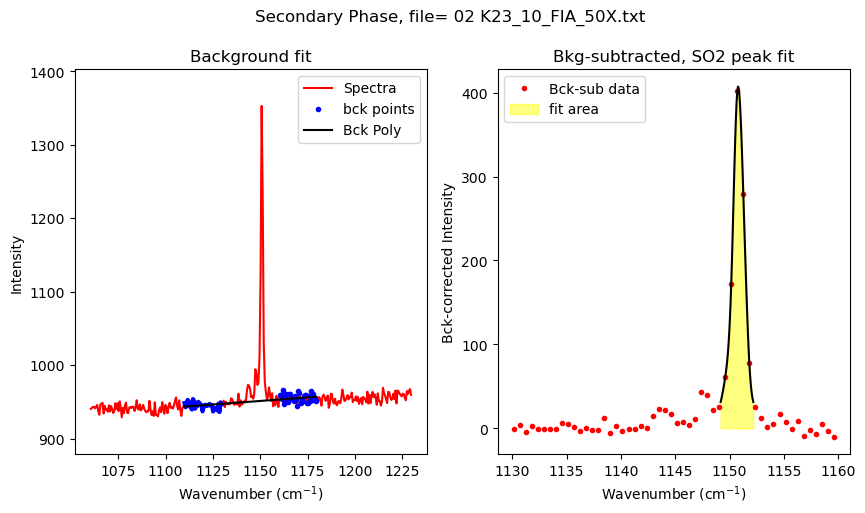

In [23]:
if sum(SO2_filter)>0:
    SO2_peak_config=pf.generic_peak_config(name='SO2', lower_bck=[1110, 1130],
    upper_bck=[1160, 1180], cent=1150, x_range_bck=5, N_peaks=1,   model_name='Spline', int_cut_off=0.08)
    print(SO2_peak_config)

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
    path=spectra_path, filename=filename, filetype=filetype, 
     plot_figure=True)

## Now lets loop through files

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.94it/s]


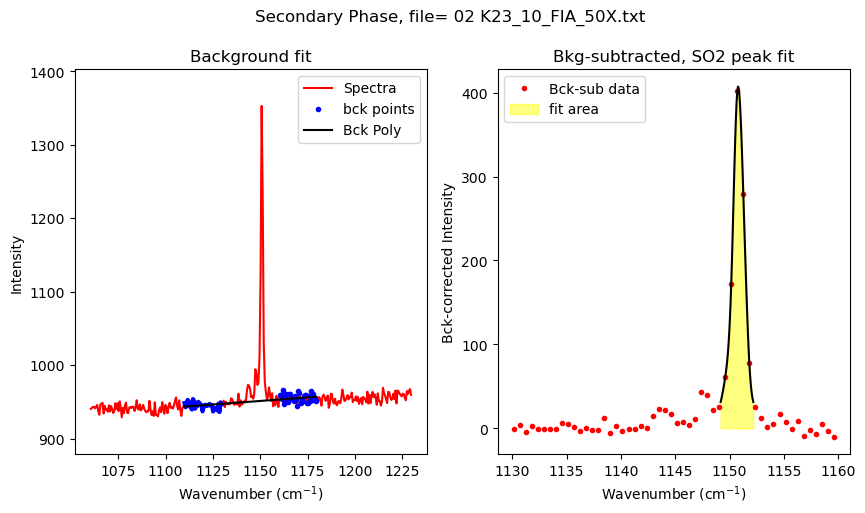

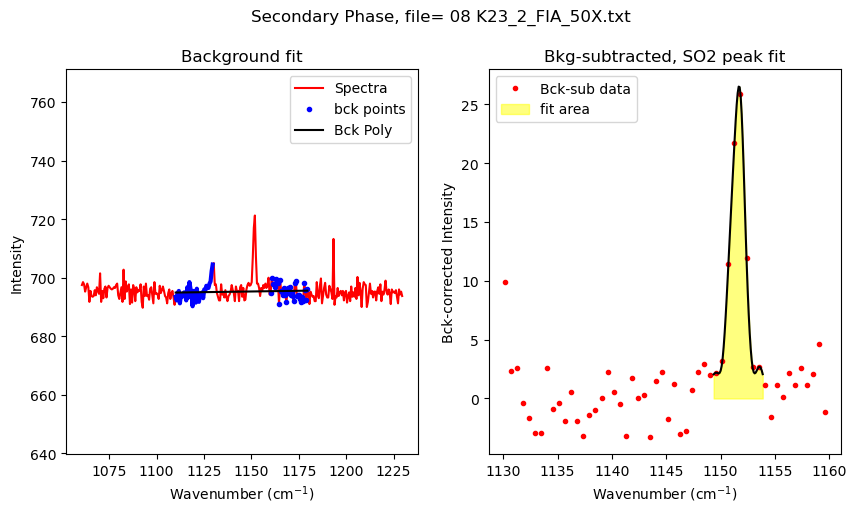

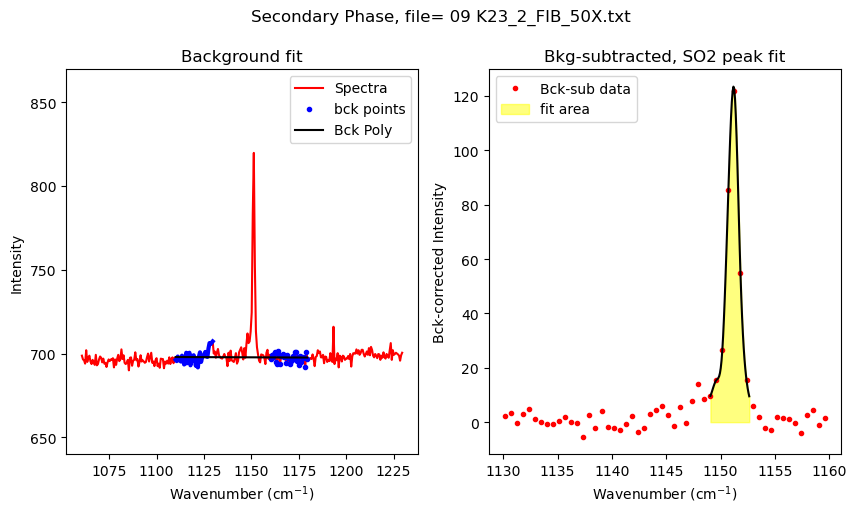

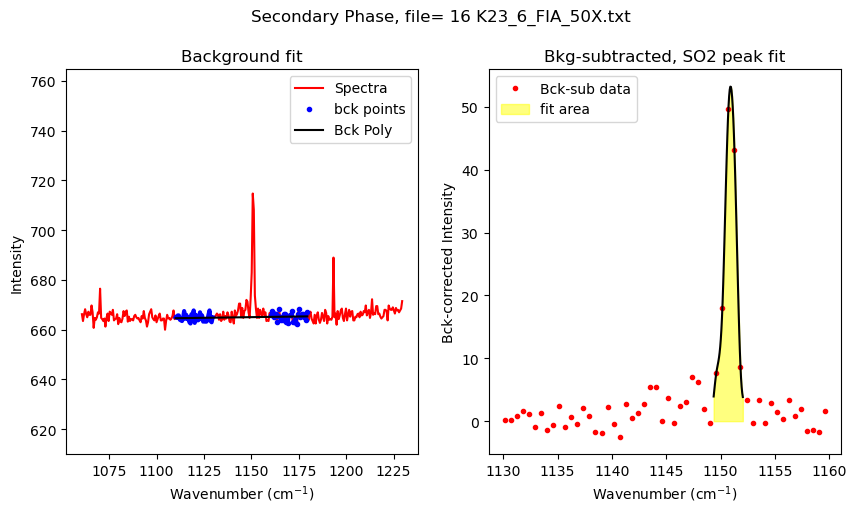

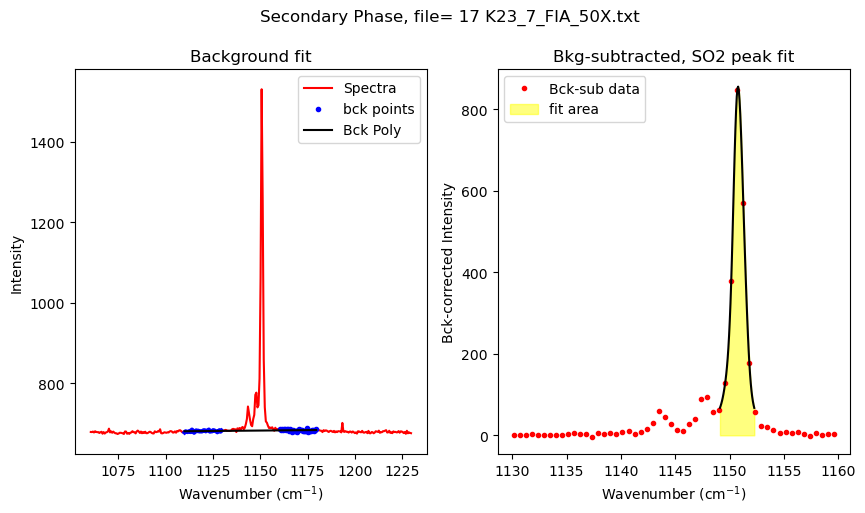

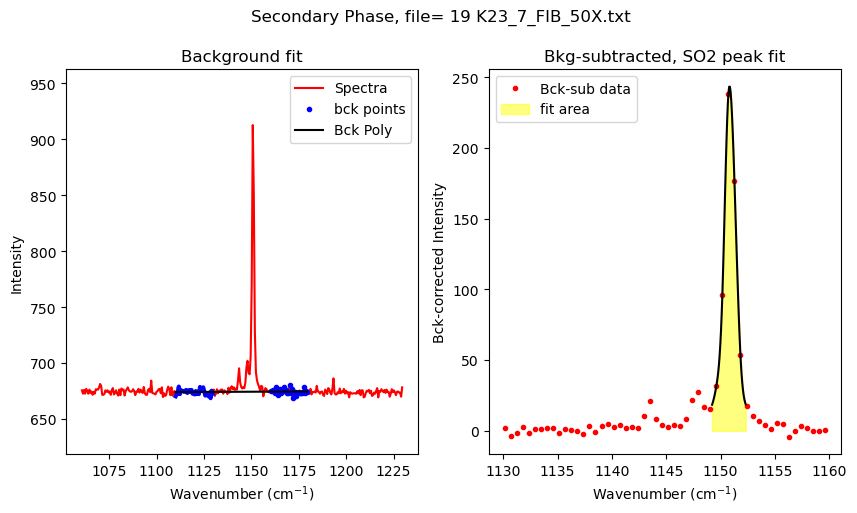

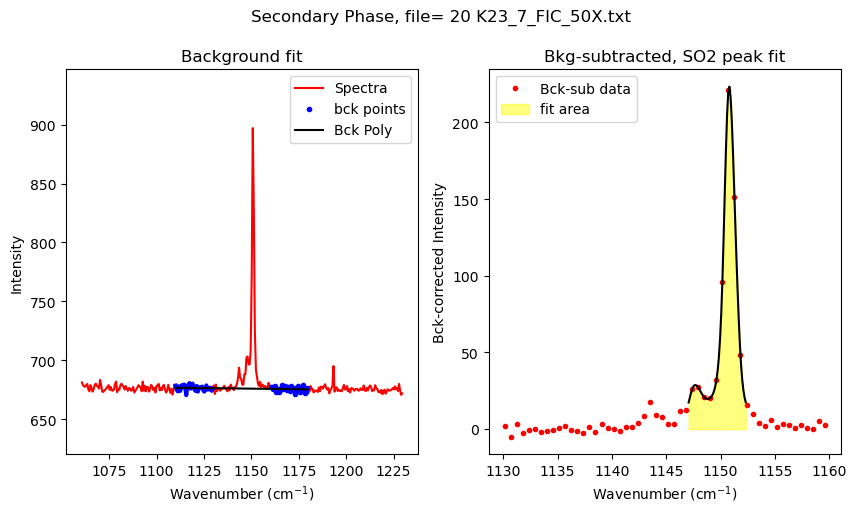

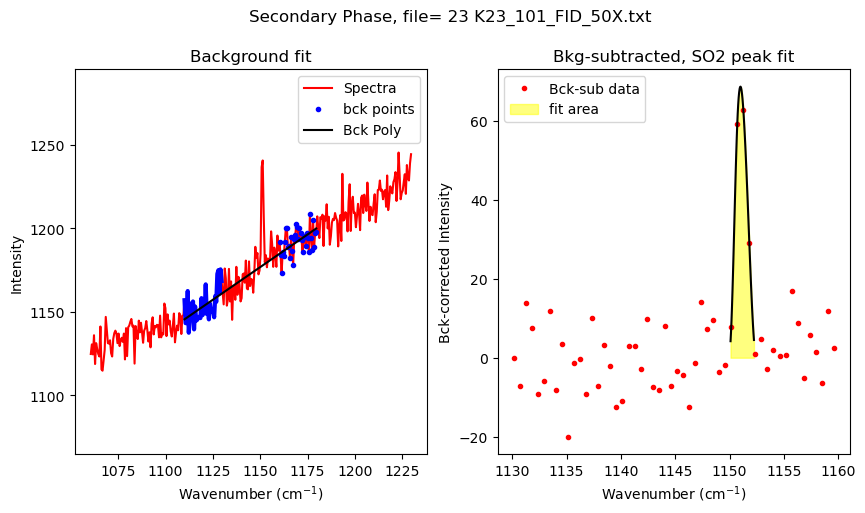

In [24]:
files_to_fit=filenames_SO2
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_SO2 = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
path=spectra_path, filename=filename, filetype=filetype,
 plot_figure=plot_figure)
 
    df_Merge_SO2 = pd.concat([df_Merge_SO2, SO2_peak_fit], axis=0)

In [25]:
df_Merge_SO2

,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name
0,02 K23_10_FIA_50X.txt,1150.799077,556.882060,401.495677,Spline
0,08 K23_2_FIA_50X.txt,1151.683997,45.472868,25.928212,Spline
0,09 K23_2_FIB_50X.txt,1151.182542,180.000721,121.986288,Spline
0,16 K23_6_FIA_50X.txt,1150.917066,70.083444,49.684694,Spline
0,17 K23_7_FIA_50X.txt,1150.769579,1193.886885,847.691989,Spline
0,19 K23_7_FIB_50X.txt,1150.828574,336.800686,238.244127,Spline
0,20 K23_7_FIC_50X.txt,1150.769579,361.113581,220.984940,Spline
0,23 K23_101_FID_50X.txt,1151.005558,88.452793,62.878907,Spline


### Plot peak areas and peak heights

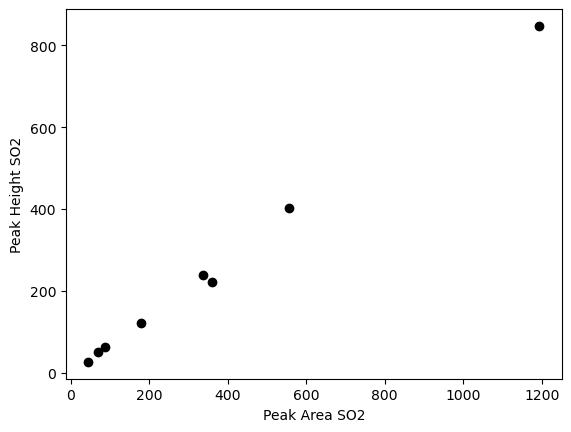

In [26]:
if sum(SO2_filter)>0:
    plt.plot(df_Merge_SO2['Peak_Area_SO2'], 
            df_Merge_SO2['Peak_Height_SO2'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
    # plt.yscale('log')
# plt.xscale('log')

### Save this to excel

In [27]:
if sum(SO2_filter)>0:
    df_Merge_SO2.to_excel('SO2_Peak_fits.xlsx', index=False)

## Now do the same to ID any carbonate peaks

## Using scipy find peaks methods

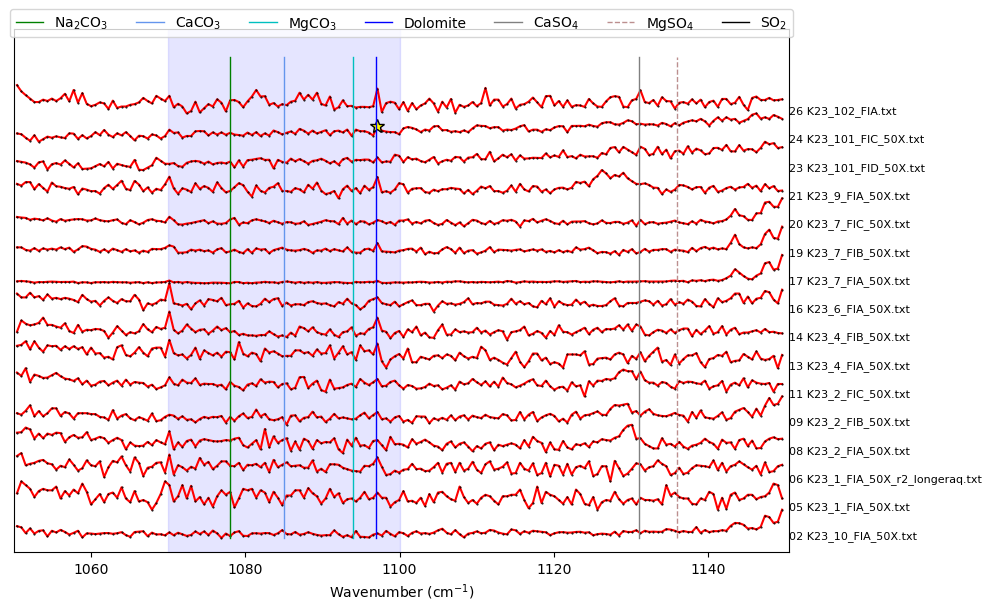

In [28]:

prominence_carb=30
height_carb=10
width_carb=1
threshold_carb=1

Carb_peaks_scipy, x_data_scipy, y_data_scipy, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=filetype, find_peaks_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1070, 1100], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)
Carb_peaks=Carb_peaks_scipy

## Find ones with certain peak parameters to include

In [29]:
Carb_noNa=np.isnan(Carb_peaks['pos'])
prom_filter=30
Carb_filter=((Carb_peaks['prom']>prom_filter))&(~Carb_noNa)
print('Number kept with this filter:')
print(sum(Carb_filter))
print('Number discarded:')
print(sum(~Carb_filter&(~Carb_noNa)))
filenames_Carb=list(File_df['filename'].loc[Carb_filter])
print('filenames with carb:')
print(filenames_Carb)

Number kept with this filter:
0
Number discarded:
1
filenames with carb:
[]


### Fit one to tweak parameters

In [30]:
if sum(Carb_filter)>0:
    filename_carb=filenames_Carb[0]

    Carb_peak_config=pf.generic_peak_config(name='Carb', lower_bck=[1050, 1070],
    upper_bck=[1120, 1150], cent=1090, x_range_bck=50, N_poly_carb_bck=2, model_name='Spline')
    print(Carb_peak_config)

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
    path=spectra_path, filename=filename_carb, filetype=filetype,
     plot_figure=True)

### Loop over all carbonate files

In [31]:
files_to_fit=filenames_Carb
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_Carb = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
path=spectra_path, filename=filename, filetype=filetype,
 plot_figure=plot_figure)
 
    df_Merge_Carb = pd.concat([df_Merge_Carb, Carb_peak_fit], axis=0)

0it [00:00, ?it/s]


In [32]:
if sum(Carb_filter)>0:
    plt.plot(df_Merge_Carb['Peak_Area_Carb'], 
        df_Merge_Carb['Peak_Height_Carb'], 'ok')
    plt.xlabel('Peak Area Carb')
    plt.ylabel('Peak Height Carb')
# plt.yscale('log')
# plt.xscale('log')

## Save to excel

In [33]:
if sum(Carb_filter)>0:
    df_Merge_Carb.to_excel('Carb_Peak_fits.xlsx', index=False )

In [34]:
df_Merge_Carb

""
